# Big Data y Machine Learning para clasificación de galaxias

- [Machine Learning - SPARK](#ml)
    - [Carga de datos CSV](#load)
    - [Filtrado de imágenes no clasificadas](#filtrado)
    - [Principal Component Analysis](#pca)
    - [Regresión Logística](#lr)
    - [Red Neuronal - Perceptrón Multicapa](#perceptron)


    
<div id='xx' />

<div id='ml' />

## Machine Learning - SPARK

`MLlib` es la librería de SPARK de aprendizaje automático cuyo objetivo es hacer machine learning escalable y sencillo. Se compone de algortimos comunes de aprendizaje y utilidades e incluye clasificación, regresión, clustering, filtros colaborativos, reducción de dimensionalidad así como primtivas de optimización de bajo nivel y APIs de flujo de alto nivel.

Está formado por dos paquetes:

- ***Spark.mllib***, que contiene el API original sobre RDDs.

- ***Spark.ml***, proporciona APIs de más alto nivel contruidas sobre dataframes.

Los conceptos claves introducidos por el API de [Spark.ml](https://spark.apache.org/docs/latest/ml-guide.html) son los siguientes:

- **Dataframe**: Spark ML usa los dataframes de Spark SQL como dataset principales para tareas de ML.

- **Transformer**: se trata de un algoritmo que puede transformar un dataframe en otro dataframe, por ejemplo, un modelo de ML es un *Transformer* que transforma un dataframe con variables predictoras en otro con predicciones.

- **Estimator**: es un algoritmo que se puede aplicar sobre un dataframe para producir un *Transformer*. Por ejemplo, un algoritmo de aprendizaje es un *Estimator* que se entrena con un dataframe y produce un modelo.

- **Pipeline**: encadena múltiples *Transformes* y *Estimators* juntos especificando un flujo de trabajo ML.

- **Parameter**: todos los *Transformer* y *Estimators* comparten ahora un API para especificar los parámetros.

Como salida a la aplicación de cada uno de los algoritmos se obtiene un objeto tipo *model* de la clase correspondiente. Por ejemplo, si aplicamos `LinearRegresion` obtenemos `LineaRegresionModel`.

---

<div id='load' />

### Carga de datos CSV

Vamos a cargar el fichero *T_F_DR14_ZooSpec_10000.csv*, que contiene las features que utilizaremos para nuestros modelos de machine learning, en un dataframe de Spark. Primero iniciaremos una `SparkSession` con la opción `spark.driver.memory=3g`.

Hemos guardado nuestros datos en formato `string` por lo que, al cargar los datos, necesitamos cambiar el formato de las variables para llevar a cabo nuestros cálculos. Así pues construiremos la estructura de nuestros *tipos de datos*.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType
import time

spark = SparkSession.builder.appName('galaxias').config('spark.driver.memory', '3g').getOrCreate()

# Lista con el nombre de las columnas features
pixel = ['F'+str(i) for i in range(0, 4096)]

Stru = [StructField('dr7objid', StringType(), True), 
        StructField('target', IntegerType(), True)]
newStru = [StructField(pixel[i], DoubleType(), True) for i in range(0, 4096)]

for j in newStru:
    Stru.append(j)
    
final_schema = StructType(fields = Stru)
df_new = spark.read.csv('data/T_F_DR14_ZooSpec_10000.csv', schema=final_schema)
df_new.count()

10001

In [2]:
df_new.dtypes

[('dr7objid', 'string'),
 ('target', 'int'),
 ('F0', 'double'),
 ('F1', 'double'),
 ('F2', 'double'),
 ('F3', 'double'),
 ('F4', 'double'),
 ('F5', 'double'),
 ('F6', 'double'),
 ('F7', 'double'),
 ('F8', 'double'),
 ('F9', 'double'),
 ('F10', 'double'),
 ('F11', 'double'),
 ('F12', 'double'),
 ('F13', 'double'),
 ('F14', 'double'),
 ('F15', 'double'),
 ('F16', 'double'),
 ('F17', 'double'),
 ('F18', 'double'),
 ('F19', 'double'),
 ('F20', 'double'),
 ('F21', 'double'),
 ('F22', 'double'),
 ('F23', 'double'),
 ('F24', 'double'),
 ('F25', 'double'),
 ('F26', 'double'),
 ('F27', 'double'),
 ('F28', 'double'),
 ('F29', 'double'),
 ('F30', 'double'),
 ('F31', 'double'),
 ('F32', 'double'),
 ('F33', 'double'),
 ('F34', 'double'),
 ('F35', 'double'),
 ('F36', 'double'),
 ('F37', 'double'),
 ('F38', 'double'),
 ('F39', 'double'),
 ('F40', 'double'),
 ('F41', 'double'),
 ('F42', 'double'),
 ('F43', 'double'),
 ('F44', 'double'),
 ('F45', 'double'),
 ('F46', 'double'),
 ('F47', 'double'),
 ('F4

<div id='filtrado' />

### Filtrado de imágenes no clasificadas

Para el entrenamiento no nos hacen falta todos los datos, nos basta con los datos de aquellas imágenes que se han clasificado satisfactoriamente. Así pues, vamos a descartar aquellas imágenes cuyo campo `target` tiene valor `0` y que corresponde a la clase `uncertain`.

In [3]:
df_new.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|  null|    1|
|     1| 4000|
|     2| 4000|
|     0| 2000|
+------+-----+



Vemos que nuestro dataframe cuenta con valores nulos. Estos valores corresponden con la fila `header`de nuestro dataset `.csv` (pues se ha incluido como fila al seleccionar nuestro propio `header` en base a nuestro `schema` con las variables tipo *string, int, double*).

In [4]:
df_new = df_new.na.drop(subset=['target'])
df_new.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 4000|
|     2| 4000|
|     0| 2000|
+------+-----+



Ahora sí podemos construir un nuevo dataframe solamente con las imágenes clasificadas:

In [5]:
labeled_df = df_new.filter(df_new['target'] != 0)
unlabeled_df = df_new.filter(df_new['target'] == 0)

labeled_df.count()

8000

Para liberar espacio en memoria eliminamos las variables que no usaremos posteriormente.

In [6]:
del df_new, Stru, newStru, final_schema, j

<div id='pca' />

### Principal Component Analysis (PCA)

Los datos (atributos) de nuestro dataframe no son los ideales para entrenar un modelo de clasificación debido a los siguientes factores:

- **Tamaño**: nuestro dataset cuenta con 8000 filas * 4096 columnas ~ 32M celdas, lo que resulta demasiado grande.

- **Densidad**: hay pocas muestras (8000) para el número de atributos (4096 píxeles). De intentar aplicar algunos algoritmos de clasificación sobre este conjunto de datos podríamos incurrir en la [maldición de la dimensión](https://es.wikipedia.org/wiki/Maldici%C3%B3n_de_la_dimensi%C3%B3n)

Para solucionar ambos problemas utilizaremos el método PCA para reducir el número de atributos.

Antes de aplicar PCA tenemos que estandarizar los datos, esto significa que todos los atributos estén centrados en `0` (tengan media `0`). Esto lo haremos mediante la clase `StandardScaler`. Posteriormente aplicamos PCA con 64 componentes principales.

In [7]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler as VA
from pyspark.sql.functions import udf

start_time = time.time()

# Construcción del assmebler
assembler = VA(inputCols=pixel, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=False, withMean=True)

data_labeled = assembler.transform(labeled_df)
scalerModel_labeled = scaler.fit(data_labeled)
labeled_df_scaled = scalerModel_labeled.transform(data_labeled)

data_unlabeled = assembler.transform(unlabeled_df)
scalerModel_unlabeled = scaler.fit(data_unlabeled)
unlabeled_df_scaled = scalerModel_unlabeled.transform(data_unlabeled)

print('Conjunto de datos estandarizados: ')
labeled_df_scaled.select('features', 'scaledFeatures').show(3)

# Aplicamos PCA con 64 componentes
pca = PCA(k=64, inputCol='scaledFeatures', outputCol='pca_scaled_features')
pca_model_labeled = pca.fit(labeled_df_scaled)
pca_model_unlabeled = pca.fit(unlabeled_df_scaled)

pca_data_labeled = pca_model_labeled.transform(labeled_df_scaled)
pca_data_unlabeled = pca_model_unlabeled.transform(unlabeled_df_scaled)

print('Porcentaje de varianza explicada por las 64 componentes (labeled): ', pca_model_labeled.explainedVariance.sum())
print('Porcentaje de varianza explicada por las 64 componentes (unlabeled): ', pca_model_unlabeled.explainedVariance.sum())

# Extraemos la primera y segunda componente
p1 = udf(lambda v:float(v[0]), FloatType())
p2 = udf(lambda v:float(v[1]), FloatType())
pca_data_labeled = pca_data_labeled.withColumn('pca1', p1('pca_scaled_features')).withColumn('pca2', p2('pca_scaled_features'))

print('Tiempo de ejecución PCA: ', (time.time() - start_time) / 60, 'minutos')

Conjunto de datos estandarizados: 
+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.0,0.0,0.0,0.0,...|[-0.0288230392156...|
|[0.08235294117647...|[0.05352990196078...|
|[0.01176470588235...|[-0.0170583333333...|
+--------------------+--------------------+
only showing top 3 rows

Porcentaje de varianza explicada por las 64 componentes (labeled):  0.9508576827227956
Porcentaje de varianza explicada por las 64 componentes (unlabeled):  0.9178454514342985
Tiempo de ejecución PCA:  10.25500640074412 minutos


Tras la PCA obtenemos un nuevo dataset con tan solo 64 variables. El motivo de entrenar el modelo con 64 componentes es que, como vemos, son capaces de explicar el 95% de la varianza de nuestros datos.

Por otro lado, hemos definido una función `udf` para mostrar a continuación algunas estadísticas de las dos primeras componentes.

In [8]:
pca_data_labeled.sample(withReplacement=None, fraction=0.1, seed=30).select('dr7objid', 'target','pca1','pca2').toPandas()

,dr7objid,target,pca1,pca2
0,588017111292706916,2,3.662173,0.623204
1,588010359623647368,2,-3.626751,-0.309870
2,587733441591968236,2,2.438550,-0.671819
3,587736479199068320,2,0.945769,-0.381338
4,587739720294727804,2,1.337411,0.928217
...,...,...,...,...
795,587725817480741085,1,0.157577,-0.740672
796,587741708882215010,1,2.877990,-0.200898
797,588017990156681365,1,-1.174694,-0.964829
798,588017116122251384,1,0.788894,0.054856


In [9]:
pca_data_labeled.select('pca1', 'pca2').describe().toPandas()

,summary,pca1,pca2
0,count,8000,8000
1,mean,4.18808212998556E-10,-5.812871677335351E-10
2,stddev,4.065633137228582,1.1099926774666153
3,min,-25.194443,-5.5221915
4,max,6.495291,5.876526


Para finalizar guardamos nuestro nuevo conjunto de datos reducidos por PCA a formato `.parquet`. El formato parquet es un formato open-source de almacenamiento en columnas para HADOOP que fue creado para poder disponer de un formato libre de compresión y codificación eficiente.

*Nota: no hay inconveniente en guardar en este formato a pesar de que no nos encontramos en un entorno HDFS. En el caso de haber seguido trabajando en nuestro entorno Cloudera podemos comprobar que nuestros datos han sido guardados en HDFS tecleando la sentencia `hdfs dfs -ls -h pca_data_labeled.parquet`.*

In [10]:
pca_data_labeled.select('dr7objid', 'target', 'pca_scaled_features').write.save('models/pca-data-labeled.parquet', format='parquet', mode='overwrite')
pca_data_unlabeled.select('dr7objid', 'target', 'pca_scaled_features').write.save('models/pca-data-unlabeled.parquet', format='parquet', mode='overwrite')

In [11]:
del pixel, p1, p2, data_labeled, data_unlabeled, labeled_df, unlabeled_df, PCA, pca, pca_model_labeled, pca_model_unlabeled, assembler, StructType, StructField, StandardScaler, VA, scaler, scalerModel_labeled, scalerModel_unlabeled, start_time

In [12]:
who_ls

['DoubleType',
 'FloatType',
 'IntegerType',
 'SparkSession',
 'StringType',
 'get_notebook_slug',
 'labeled_df_scaled',
 'pca_data_labeled',
 'pca_data_unlabeled',
 'spark',
 'time',
 'udf',
 'unlabeled_df_scaled']

<div id='lr' />

### Regresión Logística

En esta sección aplicaremos un algoritmo de regresión logística para la clasificación de la imágenes de galaxias. Para poder aplicar el modelo, el valor que contiene la clase `target` debe ser de tipo `double` (número real) tal como hemos indicado al cargar el dataset. Para facilitar los valores de la clase mapeamos el valor del `target` a `[0, 1]` tal que:

- **elíptica** = 1 -> 0
- **espiral** = 2 -> 1

Para entrenar el modelo dividiremos nuestro dataset en dos subsets más pequeños:

- **df_train**: para el entrenamiento del modelo con un 70% de los datos.
- **df_test**: para la validación del modelo con un 30% de los datos.

In [13]:
df_labeled = pca_data_labeled.withColumn('label', (pca_data_labeled['target'] - 1).astype('double'))['dr7objid', 'pca_scaled_features', 'label']
df_labeled.dtypes

[('dr7objid', 'string'),
 ('pca_scaled_features', 'vector'),
 ('label', 'double')]

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
from pyspark.ml.classification import LogisticRegression

start_time = time.time()

(df_train, df_test) = df_labeled.randomSplit([0.7, 0.3], seed=30)

lr = LogisticRegression(maxIter=100,
                         labelCol='label',
                         featuresCol='pca_scaled_features',
                         tol=1e-18,
                         regParam=0.003)
                     
lr_model = lr.fit(df_train)
pred_df_train = lr_model.transform(df_train)
pred_df_test = lr_model.transform(df_test)

# Parámetros del modelo
print('Intercept: {0}'.format(lr_model.interceptVector))
print('Coefficients: {0}'.format(lr_model.coefficientMatrix))
print(" ")
print("Tabla de predicciones:")
pred_df_test.select('label', 'prediction', 'rawPrediction', 'probability').show(5)

# Métricas
ev = BCE(rawPredictionCol='rawPrediction', labelCol='label')
print('areaUnderROC training: {0}'.format(ev.evaluate(pred_df_train, {ev.metricName: 'areaUnderROC'})))
print('areaUnderROC test: {0}'.format(ev.evaluate(pred_df_test, {ev.metricName: 'areaUnderROC'})))
print('Tiempo de ejecución del modelo: ', (time.time() - start_time) / 60, 'segundos')

Intercept: [0.09572493195272276]
Coefficients: DenseMatrix([[ 0.12616105,  0.05928831, -0.06598701, -0.18281   , -0.08827192,
               1.4135743 , -0.19605137,  0.53095949,  0.74224759, -0.36024834,
               0.63622761, -2.43367083, -0.05013847, -0.42567905,  0.25198457,
              -1.12029261, -0.26303443, -1.60177181,  0.25443744,  0.00575385,
               0.05752281, -0.32694192,  1.88792814,  0.12151816, -0.30690983,
               0.32749461, -0.29244191, -0.19674352, -1.06194808,  1.19590373,
              -0.50357229, -0.29024184,  0.93287578,  0.30590975, -1.21041213,
              -0.0709172 , -0.11912453, -0.3879142 ,  0.89187544, -0.16395627,
              -0.20713383,  0.07050712, -0.04294758, -0.0670016 ,  0.5723421 ,
              -0.88023931, -1.54944101,  0.13642675,  0.52790238,  0.38215931,
               1.43516435,  0.61943596,  0.30491326,  0.6147823 ,  0.36021235,
              -0.09203185,  0.05511555,  0.45572725,  0.5633913 , -0.03767695,
     

Definimos la función `confussion_matrix()` para calcular algunas métricas de nuestro modelo.

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE

def confussion_matrix(pred_df, label_col='label', pred_col='prediction'):

    cm = pred_df.groupBy('label', 'prediction').count().sort('label', 'prediction')
    cm.show()

    TN = cm.filter((cm.label == 0) & (cm.prediction == 0)).collect()[0][2]
    FP = cm.filter((cm.label == 0) & (cm.prediction == 1)).collect()[0][2]
    FN = cm.filter((cm.label == 1) & (cm.prediction == 0)).collect()[0][2]
    TP = cm.filter((cm.label == 1) & (cm.prediction == 1)).collect()[0][2]

    N = TN + FP + TP + FN

    prevalencia = (TP + FN) / N
    sensibilidad = TP / (TP + FN)
    especificidad  = TN / (TN + FP)
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / N

    print('Prevalencia: ', prevalencia)
    print('Sensibilidad/Recall: ', sensibilidad)
    print('Especificidad: ', especificidad)
    print('Precision: ', precision)
    print('Accuracy: ', accuracy)
    #print('Accuracy (librería): ', MCE(metricName = 'weightedRecall').evaluate(pred_df))
    
    return cm

In [16]:
confussion_matrix(pred_df_test, label_col='label', pred_col='prediction')

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  990|
|  0.0|       1.0|  200|
|  1.0|       0.0|  349|
|  1.0|       1.0|  843|
+-----+----------+-----+

Prevalencia:  0.5004198152812762
Sensibilidad/Recall:  0.7072147651006712
Especificidad:  0.8319327731092437
Precision:  0.8082454458293384
Accuracy:  0.7695214105793451


DataFrame[label: double, prediction: double, count: bigint]

Vemos que todos los indicadores de la bondad del modelo son bastante buenos. En particular podemos destacar que el porcentaje de aciertos `accuracy` es del 76%.

También analizaremos la bondad del modelo a través de una curva `ROC`.

+------------------+--------------------+-----+--------------------+--------------------+----------+----------+
|          dr7objid| pca_scaled_features|label|       rawPrediction|         probability|prediction|     probs|
+------------------+--------------------+-----+--------------------+--------------------+----------+----------+
|587722983367115056|[-3.0814534282898...|  1.0|[0.97077007799581...|[0.72527296405663...|       0.0|0.27472705|
|587724197746114857|[3.23231067031058...|  1.0|[-3.6952627866282...|[0.02423881047022...|       1.0| 0.9757612|
|587724198283051190|[0.19808845739310...|  1.0|[-3.7138376086561...|[0.02380335269645...|       1.0|0.97619665|
|587725039557738654|[3.03885202349184...|  1.0|[-2.3893102713815...|[0.08399148226438...|       1.0|0.91600853|
|587725039561474199|[3.38592250526756...|  1.0|[1.26764899941088...|[0.78034002976135...|       0.0|0.21965997|
|587725074994823341|[2.51650169544883...|  1.0|[-0.1134565221206...|[0.47166625651632...|       1.0| 0.5

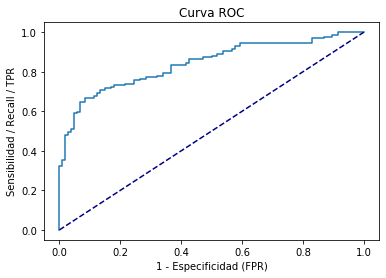

areaUnderROC test: 0.8294653431842536


In [17]:
#from pyspark.sql.functions import udf
#from pyspark.sql.types import FloatType
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

second_element = udf(lambda v: float(v[1]), FloatType())
pred2 = pred_df_test.withColumn('probs', second_element('probability'))

pred2.show(10)

# Gráfica
pred2 = pred2.sample(False, fraction=0.1, seed=30).select('label', 'probs').toPandas()
fpr, tpr, _ = roc_curve(pred2['label'], pred2['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlabel('1 - Especificidad (FPR)')
plt.ylabel('Sensibilidad / Recall / TPR')
plt.title('Curva ROC')
plt.show()

print('areaUnderROC test: {0}'.format(ev.evaluate(pred_df_test, {ev.metricName: 'areaUnderROC'})))

El valor del área bajo la curva nos da una idea del poder de clasificación del modelo:

- ~ 1 tenemos un clasificador perfecto.
- ~ 0,5 nos encontramos con un clasificador aleatorio.
- ~ 0 nuestro modelo es un clasificador invertido.

Veamos qué clasificación obtenemos según nuestro modelo para el dataset de objetos no etiquetados. Primero que nada transformamos el `target` a `label` como hemos hecho para los datos etiquetados.

In [18]:
df_unlabeled = pca_data_unlabeled.withColumn('label', (pca_data_unlabeled['target'] - 1).astype('double'))['dr7objid', 'pca_scaled_features', 'label']
df_unlabeled.dtypes

[('dr7objid', 'string'),
 ('pca_scaled_features', 'vector'),
 ('label', 'double')]

Aplicamos el modelo entrenado con el conjunto de datos etiquetados sobre los datos `pca_df_unlabeled` y usamos la función `groupBy` para ver cuántos objetos hay de cada clase en la predicción:

In [20]:
pred_df_unlabeled = lr_model.transform(df_unlabeled)
pred_df_unlabeled.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  830|
|       1.0| 1170|
+----------+-----+



Veamos a continuación un conjunto de imágenes clasificadas.

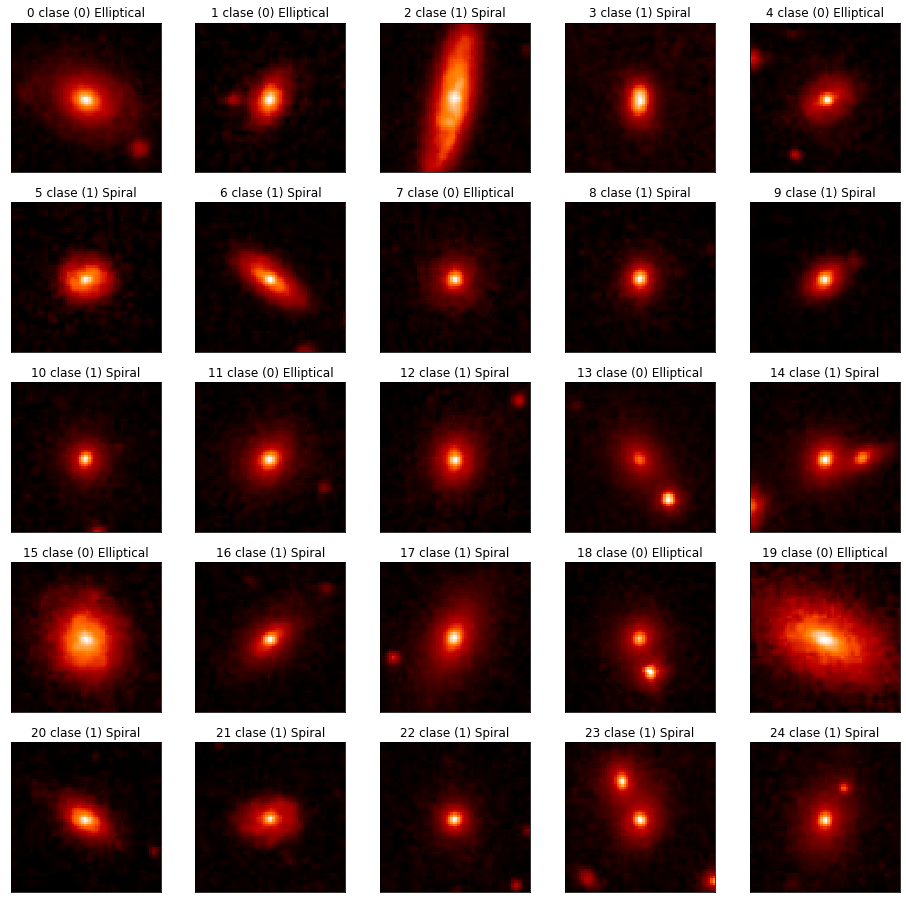

In [21]:
import cv2
obj = pred_df_unlabeled.select('dr7objid', 'prediction').toPandas()

fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for i, axi in enumerate(ax.flat):
    img = cv2.imread('image-galaxyzoo/'+obj["dr7objid"][i]+'.png', 0)
    axi.imshow(img, interpolation='nearest', cmap='gist_heat')
    #axi.imshow(img, interpolation='nearest', cmap='binary')
    if obj["prediction"][i] == 0:
        axi.set_title(str(i)+" clase (0) Elliptical")
    else:
        axi.set_title(str(i)+" clase (1) Spiral")
    axi.set(xticks=[], yticks=[])

Para finalizar guardamos nuestro modelo de regresión logística.

In [22]:
#lr_model.save('models/multilayer-perceptron-galaxy')
lr_model.write().overwrite().save('models/logistic-regression-galaxy')

Y podemos recuperarlo mediante la clase `LogisticRegressionModel`.

In [23]:
from pyspark.ml.classification import LogisticRegressionModel

lr2 = LogisticRegressionModel.load('models/logistic-regression-galaxy')
print(lr2.coefficients[0] == lr_model.coefficients[0])

True


<div id='perceptron' />

### Red Neuronal - Perceptrón Multicapa

Existen multitud de algoritmos de aprendijaze diferentes y cada uno de ellos puede rendir mejor o peor dependiendo de la tipología y distribución de los datos, la finalidad del modelo, el porcentaje de positivos, etc. Por este motivo es conveniente que valoremos la utilización de otros métodos aún obtenido un porcentaje de aciertos razonablemente bueno mediante un modelo de regresión logística.

Una de las tipologías de algoritmos más utilizadas para la clasificación de imágenes es la red neuronal. Hoy en día existen multitud de paquetes y arquitecturas de redes neuronales bastante eficientes para la clasificación de imágenes (por ejemplo redes CNN), sin embargo, en esta sección nos centraremos en una red más simple basada en el método `feedforward` llamada **perceptrón multicapa**.

##### Entrenamiento

Primero tenemos que definir la estructura de nuestra red neuronal. Una red neuronal está compuesta por capas. A su vez cada capa se compone por un conjunto de nodos. En PYSPARK, ésta estructura se define a través de una lista en que cada valor representa el número de nodos de la capa. Así pues, la lista `[5, 10, 1]` define una red neuronal de tres capas con 5, 10 y 1 nodos respecivamente mientras que la lista `[20, 10, 5, 2]` define una red de 4 capas con 20, 10, 5 y 2 nodos.

Las redes neuronales tienen 3 tipos de capas:

- Capa de entrada: solo hay una y debe tener tantos nodos como features (atributos) tenemos en el dataset. Corresponde a la primera posición de la lista.

- Capas ocultas: pueden ser varias y no tienen ninguna restricción en cuanto al número de capas ni de nodos. En general, cuantas más capas ocultas haya, más preciso será el algoritmo (aunque más costoso de entrenar).

- Capa de salida: solo hay una y debe tener tantos nodos como clases tengamos en el dataset. Corresponde a la última posición de la lista.

Así pues, para nuestro caso deberemos configurar una red neuronal con una estructura de este tipo: `[64, ..., 2]`

In [24]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE

start_time = time.time()

# Usaremos los mismos datos pred_df_labeled/pred_df_unlabeled y train/test

layers = [64, 32, 16, 8, 2]
mlp = MultilayerPerceptronClassifier(labelCol='label',
                                     featuresCol='pca_scaled_features',
                                     maxIter=100, 
                                     layers=layers, 
                                     seed=30)

mlp_model = mlp.fit(df_train)
pred_df_mlp_labeled_train = mlp_model.transform(df_train)
pred_df_mlp_labeled_test = mlp_model.transform(df_test)

pred_df_mlp_labeled_train.show(5)

evaluator = MCE(metricName="accuracy")
print('Accuracy: ', MCE(metricName = "weightedRecall").evaluate(pred_df_mlp_labeled_test))
print('Tiempo de ejecución del modelo: ', (time.time() - start_time) / 60, 'segundos')

+------------------+--------------------+-----+--------------------+--------------------+----------+
|          dr7objid| pca_scaled_features|label|       rawPrediction|         probability|prediction|
+------------------+--------------------+-----+--------------------+--------------------+----------+
|587722952767373781|[3.63106211655576...|  1.0|[-2.0715108516198...|[0.04996002429907...|       1.0|
|587722981753421997|[0.94133164111899...|  1.0|[-4.3157933261707...|[3.82197009807514...|       1.0|
|587722982271483931|[0.17135870573141...|  1.0|[-2.3406439368326...|[0.02996608259944...|       1.0|
|587722983366328355|[2.46969415400133...|  1.0|[-4.5611321245776...|[2.34203790465190...|       1.0|
|587722983372292306|[-4.5651427400731...|  1.0|[-1.9438712665970...|[0.05573986246341...|       1.0|
+------------------+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Accuracy:  0.926112510495382
Tiempo de ejecución del modelo:  1.24

In [25]:
confussion_matrix(pred_df_mlp_labeled_test, label_col='label', pred_col='prediction')

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1117|
|  0.0|       1.0|   73|
|  1.0|       0.0|  103|
|  1.0|       1.0| 1089|
+-----+----------+-----+

Prevalencia:  0.5004198152812762
Sensibilidad/Recall:  0.9135906040268457
Especificidad:  0.938655462184874
Precision:  0.9371772805507745
Accuracy:  0.926112510495382


DataFrame[label: double, prediction: double, count: bigint]

Vemos que el porcentaje de aciertos se ha incrementado con respecto al algoritmo de regresión logística. Ahora tenemos cerca de un 93% de aciertos, lo que equivale a más de un 15% de mejora en la predicción.

Aplicamos el modelo a los datos no etiquetados:

In [26]:
pred_df_mlp_unlabeled = mlp_model.transform(df_unlabeled)
print('Predicción Perceptrón Multicapa:')
pred_df_mlp_unlabeled.groupBy('prediction').count().sort('prediction').show()

Predicción Perceptrón Multicapa:
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1354|
|       1.0|  646|
+----------+-----+



El número de predicciones para la clase `0` (galaxia elíptica) prácticamente se duplica con respecto a las predicciones de nuestro modelo de regresión logística.

In [27]:
print('Predicción Regresión Logística:')
pred_df_unlabeled.groupBy('prediction').count().sort('prediction').show()

Predicción Regresión Logística:
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  830|
|       1.0| 1170|
+----------+-----+



Tenemos entonces que el modelo que tiene mayor `accuracy` predice mayor cantidad de galaxias elípticas sobre las galaxias que los usuarios no han podido clasificar. Intuitivamente podemos pensar que los resultados tienen sentido (y así parece confirmarlo el modelo). Ahondemos en esta cuestión: si tenemos dudas sobre una imagen, será porque no logramos identificar con claridad la espiral de la galaxia (o la barra si corresponde con una *galaxia espiral barrada*). Por lo tanto, tendríamos la sospecha de que dicha espiral está "camuflada" por la distribución de brillo alrededor del núcleo. Efectivamente esta es la definición que estamos dando para las galaxias elípticas: aquellas que no tienen estructura y sobre las que no logramos identificar una distribución más allá de un punto con cierto halo circular (ya que el brillo tiende a ser homogéneo alrededor de este punto).

Una conslusión interesante que nos podría estar dando nuestro modelo es la siguiente: ¿Hay mayor proporción de galaxias elípticas en nuestro Universo? Sin embargo, no podemos responder esta pregunta sin antes aplicar técnicas estadísticas más sofisticadas sobre nuestro dataset de imágenes (realmente representan una muestra significativa?). Por otro lado, si pensamos en términos físicos (en concreto física de fluidos) la respuesta es un rotundo NO ya que la mayoría de galaxias tienen forma de disco y son espirales.

A continuación comparamos nuestro nuevo modelo con las imágenes que clasificamos previamente en el modelo de regresión logística.

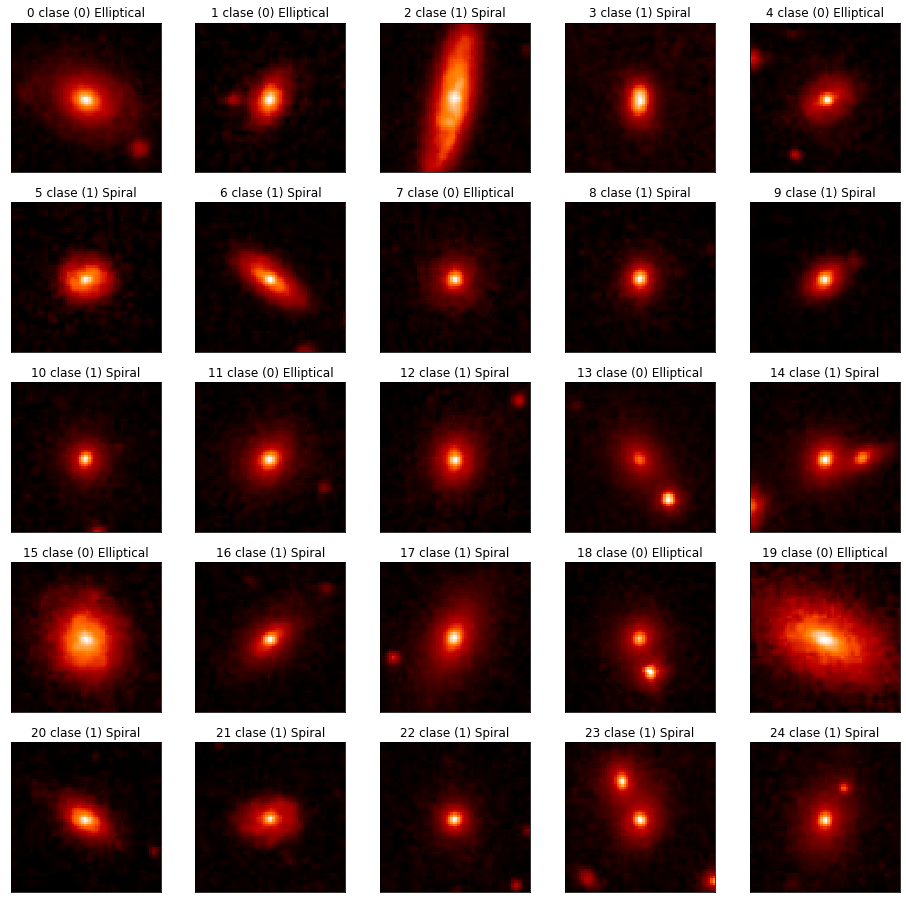

In [28]:
#import cv2
obj = pred_df_mlp_unlabeled.select('dr7objid', 'prediction').toPandas()

fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for i, axi in enumerate(ax.flat):
    img = cv2.imread('image-galaxyzoo/'+obj["dr7objid"][i]+'.png', 0)
    axi.imshow(img, interpolation='nearest', cmap='gist_heat')
    #axi.imshow(img, interpolation='nearest', cmap='binary')
    if obj["prediction"][i] == 0:
        axi.set_title(str(i)+" clase (0) Elliptical")
    else:
        axi.set_title(str(i)+" clase (1) Spiral")
    axi.set(xticks=[], yticks=[])

Guardamos nuestro modelo para clasificaciones futuras.

In [29]:
#mlp_model.save('models/multilayer-perceptron-galaxy')
mlp_model.write().overwrite().save('models/multilayer-perceptron-galaxy')

In [30]:
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

mlp2 = MultilayerPerceptronClassificationModel.load('models/multilayer-perceptron-galaxy')
print(mlp2.layers == mlp_model.layers)
print(mlp2.weights == mlp_model.weights)

True
True
